# Kendrick Mass Filter 
 __Authors:__ Ricardo R. da Silva (ridasilva@ucsd.edu), Madeleine Ernst (mernst@ucsd.edu), Alan K. Jarmusch (ajarmusch@ucsd.edu) <br>
 __Verion:__ 1.0 (Prior to Submission of Manuscript) <br>
 __Date of Last Revision:__ 06-21-2018 <br>
 
**Description**: Kendrick mass is the mass-to-charge (*m/z*) of each ion rescaled to an integer value of a given unit repeat. The defect between the Kendrick scaled *m/z* and the integer Kendrick mass value, i.e. Kendrick mass defect (KMD), is similar between homologous compounds. The Kendrick Mass Filter (MDF) is used to perform selection and removal of data centered around a user-defined KMD, with addtional restrictions on the elution time and presence of possibly multiple homologous compounds eluting together. This notebook calculates and visualizes data output obtained through the Kendrick Mass Filter for a selected dataset using user-defined parameters.

**Input**: <br>
<ul>
<li>**Feature table**: (.csv) file with MS features in columns and samples in rows. Feature IDs are provided in the column names in the following format: "mz;RT". The first column must contain sample names. </li>
</ul> <br>
**Output**: <br>
<ul>
<li>**Summary tables**: (.csv) files containing Kendrick mass filtered output data. </li>
<li>**Plots** (.pdf): Kendrick mass plot, MS1 features plot and spectra before and after applying KMF.</li>
</ul> <br> 
**Dependencies**: R version 3.4.2 (2017-09-28) and packages: tidyr_0.8.0, dplyr_0.7.4, gridExtra_2.3, gtable_0.2.0, Rgraphviz_2.22.0, graph_1.56.0, BiocGenerics_0.24.0, Hmisc_4.0-3, ggplot2_2.2.1, Formula_1.2-2, survival_2.41-3, lattice_0.20-35 

load libraries

In [2]:
library(Hmisc)
library(Rgraphviz)
library(graph)
library(ggplot2)
library(gtable)
library(grid)
library(gridExtra)
library(dplyr)
library(tidyr)

load Kendrick Mass Filter source function

In [3]:
source("kendrick.mass.filter_new_all_datamatrix_terminologyupdate.R")

# Data Input and Preparation for Kendrick Mass Filter

load data matrix (samples in rows and variables in columns)

In [4]:
data_matrix <- read.csv("all17K/tab17PEG.csv", header=T, check.names=F)
head(data_matrix)

SAMPLE,432.281884626908;2.53300454545454,476.305215199788;2.6522125,388.253383000691;2.37624166666666,520.333179050021;2.75036574074074,415.252231763756;2.53302173913043,344.228422164916;2.14777916666666,371.22840590704;2.37920158730158,459.281274159749;2.65194375,503.303718898607;2.75060072463768,⋯,402.770065307617;3.13023333333333,202.109008789062;10.37515,123.091598510742;10.1250166666666,391.201583862304;2.37786666666666,153.137969970703;8.26475,667.394714355468;2.99201666666666,407.222579956054;2.68493333333333,724.43359375;3.28585,219.17446899414;5.62343333333333,130.966156005859;1.47876666666666
20170728_MS1_17k_PEG_1,6429624506,5408429283,7514160792,4055533016,3666656651,8277896112,3977181472,2950759341,1904767377,⋯,2223329,7827148,50427613,810762,53314268,1399198,1189306,1661110,1181526,28890918
20170728_MS1_17k_PEG_2,6617665352,5505775209,7571515869,4112716607,3882034452,8206703134,0,2955649147,1960552584,⋯,0,0,0,0,0,0,0,0,0,0
20170728_MS1_17k_PEG_3,6576928427,5625211740,7567208669,4159129490,3816859834,8316890279,4083276215,3003420137,1917175859,⋯,0,0,0,0,0,0,0,0,0,0


Prepare data for Kendrick Mass Filter: create a matrix containing one column with *m/z* values and another column with RT values

In [5]:
vec <- do.call(rbind,lapply(strsplit(colnames(data_matrix)[2:ncol(data_matrix)],";"),matrix,ncol=2,byrow=TRUE))
class(vec) <- "numeric"
colnames(vec)<- c("mz","rt")
head(vec)

mz,rt
432.2819,2.533005
476.3052,2.652213
388.2534,2.376242
520.3332,2.750366
415.2522,2.533022
344.2284,2.147779


# Apply Kendrick Mass Filter to data
Parameters, which can be specified when running the mass filter: <br>
1. __Kendrick mass defect (KMD) [Da]__ - tolerance of mass defect. Smaller values result in a more stingent homology parameter. <br>
2. __Retention time (RT) [min]__ - tolerance for chromatographic elution. <br>
3. __Number of Observations (NOS)__ - how many oligomer peaks must be observed. Larger values result in more specificity. 
4. __connection_filter__ must be set to "TRUE" for NOS parameter to function correctly. <br>
5. __polymer__ - selection of polymers or signals to filter, options are:<br>
alkane_other_CH2, oxidation, water_cluster, alkane_C2H4, methanol_cluster, acetonitrile_cluster, propylation_other_C3H6, polyethylene_glycol_other_C2H4O1, perfluoro_CF2, ammoniumchloride_cluster, butylation_other_C4H8, sodiumchloride_cluster, polypropylene_glycol_other_C3H6O1, ammoniumformate_cluster, sodiumformate_cluster, potassiumchloride_cluster, polysiloxane, <br> sodiumacetate_cluster

run the Kendrick Mass Filter with user-specified parameters

In [6]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = "polyethylene_glycol_other_C2H4O1", 
    KMD = 0.01, 
    RT = 0.8, 
    NOS = 2, 
    connection_filter = TRUE)

show output table

In [7]:
output$Kendrickfiltered_MS1features_wgraph

SAMPLE,394.213268280029;2.38114166666666,522.332708185369;2.75181363636363,434.284787691556;2.53569871794871,349.226055908203;3.03508666666666,346.230796813964;2.15283888888888,362.722486707899;3.09536111111111,439.238014221191;2.53009375,242.284182341202;5.29321594202898,351.702832539876;3.03940833333333,⋯,393.1240234375;2.36386666666666,402.770065307617;3.13023333333333,202.109008789062;10.37515,123.091598510742;10.1250166666666,391.201583862304;2.37786666666666,153.137969970703;8.26475,667.394714355468;2.99201666666666,407.222579956054;2.68493333333333,219.17446899414;5.62343333333333,130.966156005859;1.47876666666666
20170728_MS1_17k_PEG_1,389419229,208552138,267331831,110655205,229265525,48109151,69257665,77122861,32664250,⋯,13141799,2223329,7827148,50427613,810762,53314268,1399198,1189306,1181526,28890918
20170728_MS1_17k_PEG_2,400710384,208948912,275215870,112018694,228195434,50538336,73139530,63206180,32331562,⋯,0,0,0,0,0,0,0,0,0,0
20170728_MS1_17k_PEG_3,396988066,207781090,270685029,110163424,229524596,46201803,72711907,78138815,32165318,⋯,0,0,0,0,0,0,0,0,0,0


# Kendrick Mass Plot

create Kendrick mass plot

In [8]:
kendrickmassfilterinfo <- as.data.frame(output$kendrickmassfilterinfo_original)
kendrickmassfilterinfo_filtered_wgraph <- as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph)
kendrickmassfilterinfo_diff <- kendrickmassfilterinfo[((kendrickmassfilterinfo[,1] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,1]) & 
                                                       (kendrickmassfilterinfo[,2] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,2])) != TRUE,]

Original MS1 features are displayed in black, and filtered MS1 features in red. Homologous compounds (polymers) can be readily identified by plotting the integer Kendrick values versus the Kendrick mass defect, resulting in a horizontal alignment in the Kendrick mass plot. 

Saving 6.67 x 6.67 in image


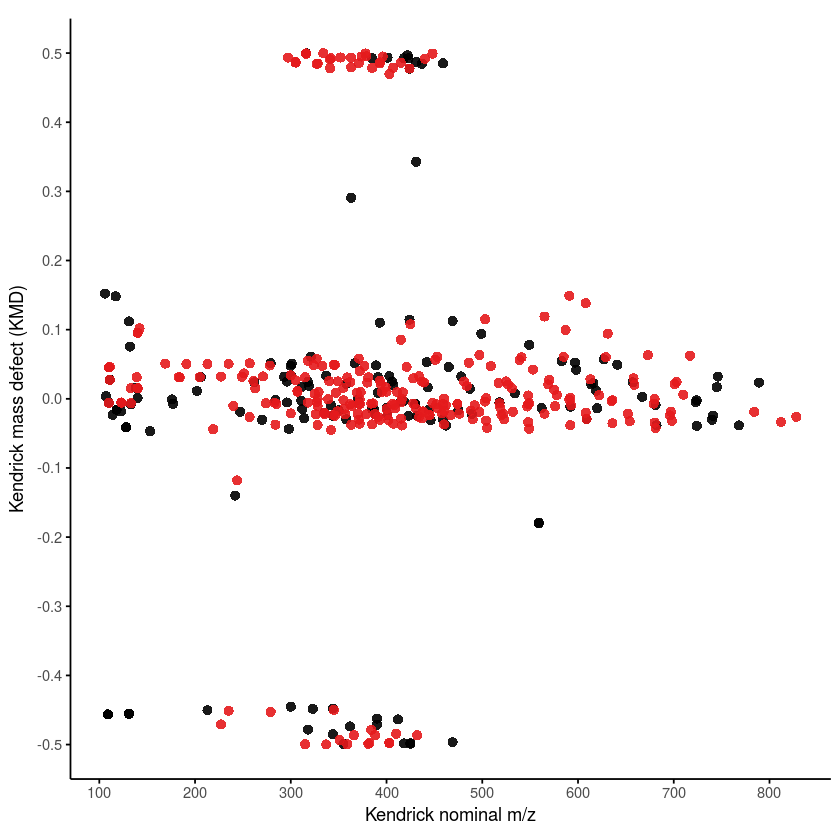

In [9]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=2.5, alpha=0.9, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=2.5, alpha=0.9,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Kendrickplot)
ggsave("Kendrickmassplot.pdf")

Following Fouquet and Sato (Anal. Chem. 2017, 89, 2682−2686) definitions of KM as

\begin{align}
KM(ion) = m/z(ion) * \frac{round(m(base\ unit))}{m(base\ unit)}
\end{align}

NKM as

\begin{align}
NKM(ion) = round(KM(ion))
\end{align}

and KMD as

\begin{align}
KMD(ion) = NKM(ion) - KM(ion)
\end{align}

and CNKM as

\begin{align}
CNKM(ion) = NKM(ion) - celling(NKM(ion)-m/z(ion))
\end{align}

The expansion of the KMD dimension is accomplished using a fractional base unit 

\begin{align}
base\ unit = \frac{(base\ unit)}{X}
\end{align}

In [10]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = "polyethylene_glycol_other_C2H4O1", 
    # Re-scale according to fraction base, for this case
    # ~ fractionBase*mass_defect_parameter*2
    KMD = 0.95,
    RT = 0.8, 
    NOS = 2, 
    connection_filter = TRUE,
    fractionBase=43)

In [11]:
kendrickmassfilterinfo <- as.data.frame(output$kendrickmassfilterinfo_original)
kendrickmassfilterinfo_filtered_wgraph <- as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph)
kendrickmassfilterinfo_diff <- kendrickmassfilterinfo[((kendrickmassfilterinfo[,1] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,1]) & 
                                                       (kendrickmassfilterinfo[,2] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,2])) != TRUE,]

Saving 6.67 x 6.67 in image


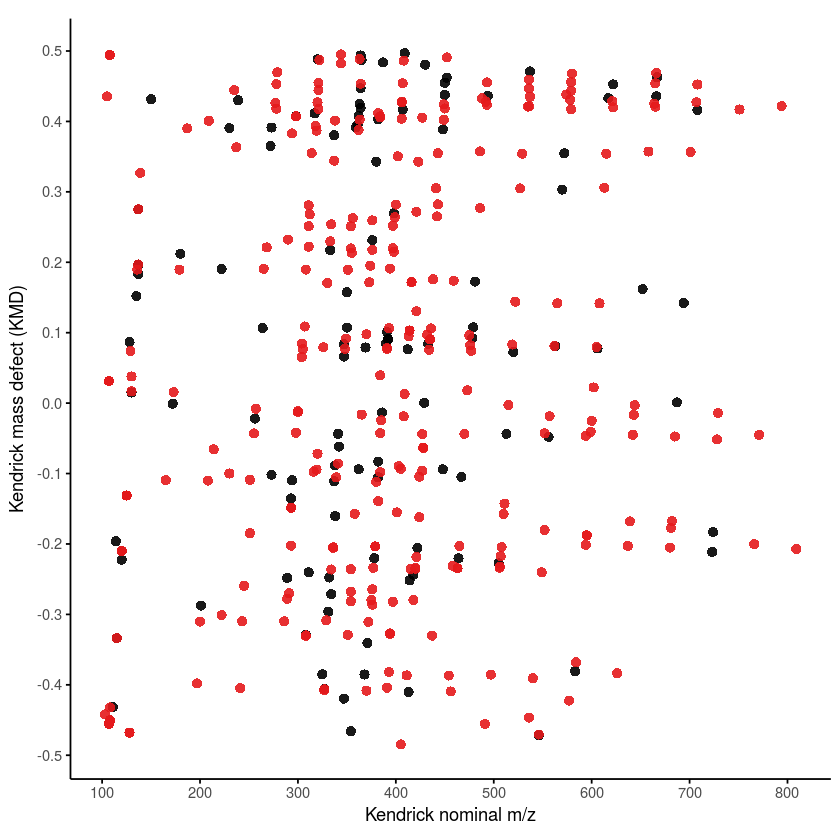

In [12]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=2.5, alpha=0.9, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=2.5, alpha=0.9,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Kendrickplot)
ggsave("Kendrickmassplot.pdf")

# MS1 Feature Plot

create MS1 feature plot

In [15]:
#colnames(output$Kendrickfiltered_MS1features_wgraph)
KMF_vec <- do.call(rbind,lapply(strsplit(colnames(output$Kendrickfiltered_MS1features_wgraph)[2:ncol(output$Kendrickfiltered_MS1features_wgraph)],";"),matrix,ncol=2,byrow=TRUE))
class(KMF_vec) <- "numeric"
colnames(KMF_vec)<- c("mz","rt")
head(KMF_vec)

mz,rt
394.2133,2.381142
522.3327,2.751814
434.2848,2.535699
349.2261,3.035087
346.2308,2.152839
362.7225,3.095361


In [16]:
Filtered_matrix_KMF_wgraph_MS1_plot_vec <- as.data.frame(vec[((vec[,1] %in% KMF_vec[,1]) & (vec[,2] %in% KMF_vec[,2])) != TRUE,])

Original MS1 features are displayed in black, and filtered MS1 features in red.

Saving 7 x 7 in image


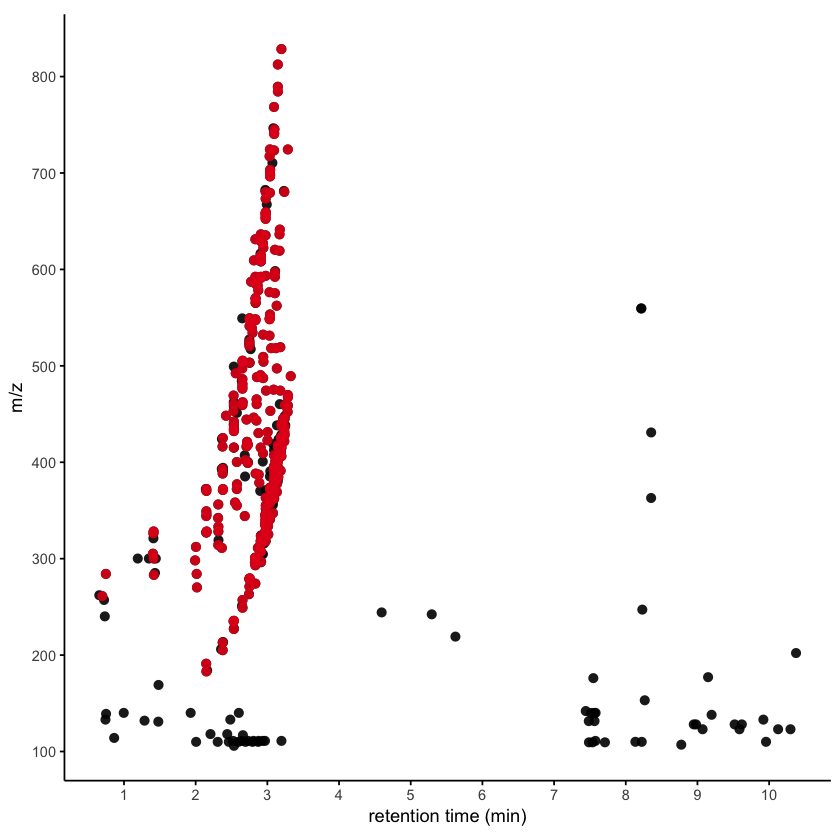

In [17]:
MS1featureplot <- 
    ggplot()+
    geom_point(data=as.data.frame(vec),aes(x=rt, y=mz), pch=16, 
              size=2.5, alpha=0.9, color="black")+
    geom_point(data=Filtered_matrix_KMF_wgraph_MS1_plot_vec, aes(x=rt, y=mz), pch=16, 
               size=2.5, alpha=0.9, col="#e41a1c")+
    scale_y_continuous(breaks = seq(0,1000,100))+
    scale_x_continuous(breaks = seq(0,10,1))+
        xlab("retention time (min)") +
        ylab("m/z") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(MS1featureplot)
ggsave("MS1featureplot.pdf")

# Plot Spectra

create MS1 feature spectrum prior to KMF

In [18]:
original_spectrum <- as.data.frame(cbind(vec,as.numeric(t(data_matrix)[2:nrow(t(data_matrix)),2])))
label <- format(round(vec[,1], 2), nsmall = 4)
original_spectrum <- cbind(original_spectrum, label)
colnames(original_spectrum) <- c("mz","rt","abundance","mz_label")
head(original_spectrum)

mz,rt,abundance,mz_label
432.2819,2.533005,6617665352,432.2800
476.3052,2.652213,5505775209,476.3100
388.2534,2.376242,7571515869,388.2500
520.3332,2.750366,4112716607,520.3300
415.2522,2.533022,3882034452,415.2500
344.2284,2.147779,8206703134,344.2300


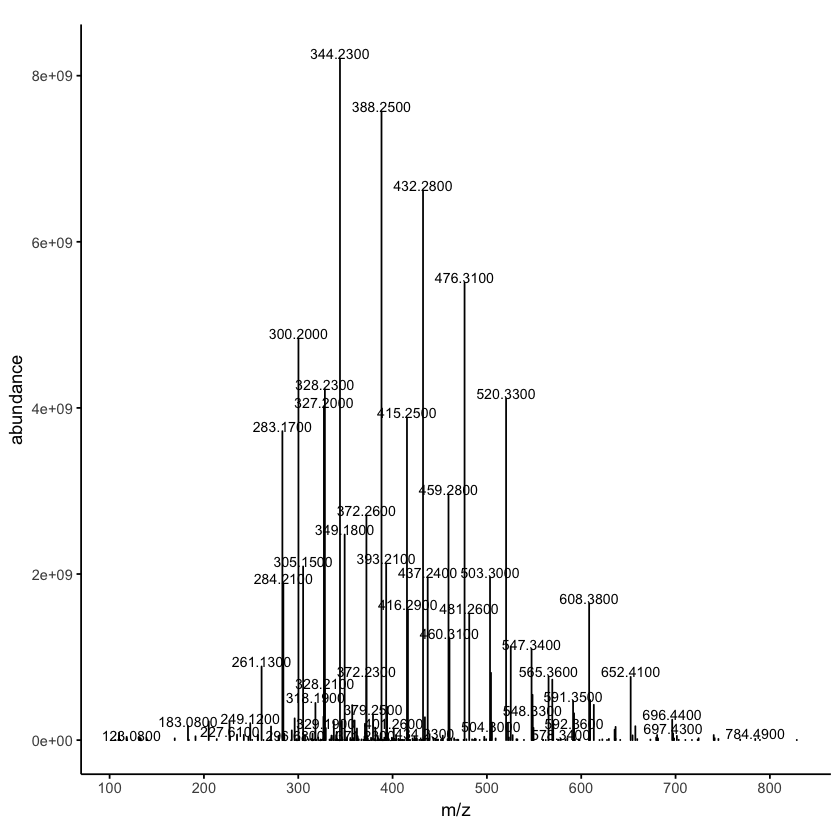

In [20]:
# Original spectrum
Original_Spectrum_plot <- 
    ggplot()+
    geom_bar(data=original_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=original_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Original_Spectrum_plot)

create MS1 feature spectrum after KMF

In [21]:
KMF_spectrum <- as.data.frame(cbind(KMF_vec,as.numeric(t(output$Kendrickfiltered_MS1features_wgraph)[2:nrow(t(output$Kendrickfiltered_MS1features_wgraph)),2])))
label <- format(round(KMF_vec[,1], 2), nsmall = 4)
KMF_spectrum <- cbind(KMF_spectrum, label)
colnames(KMF_spectrum) <- c("mz","rt","abundance","mz_label")
head(KMF_spectrum)

mz,rt,abundance,mz_label
394.2133,2.381142,400710384,394.2100
522.3327,2.751814,208948912,522.3300
434.2848,2.535699,275215870,434.2800
349.2261,3.035087,112018694,349.2300
346.2308,2.152839,228195434,346.2300
362.7225,3.095361,50538336,362.7200


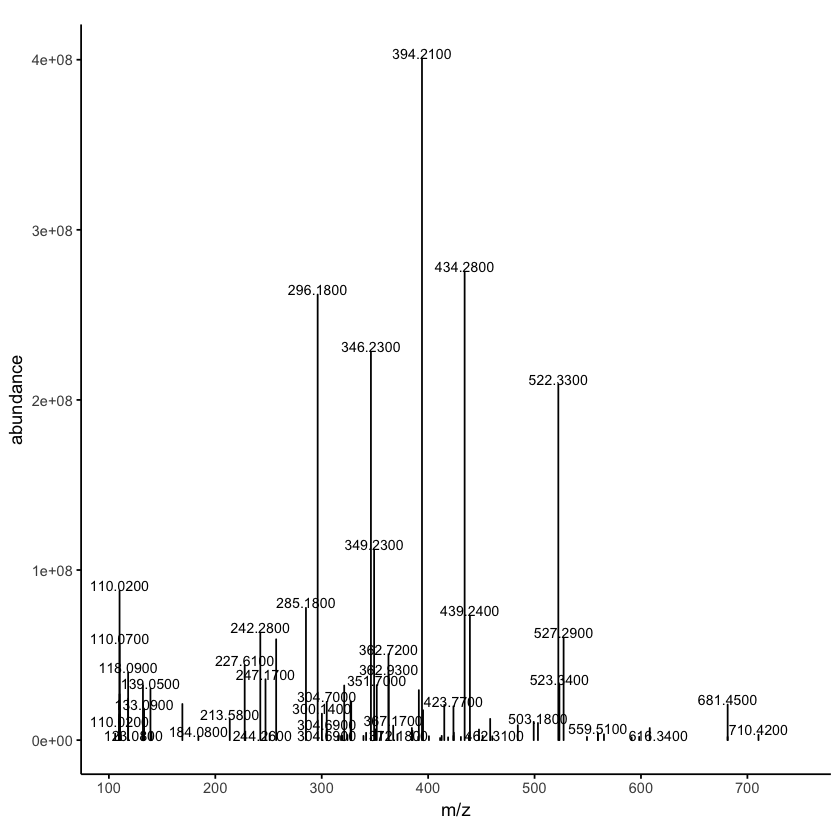

In [22]:
KMF_spectrum_plot <- 
    ggplot()+
    geom_bar(data=KMF_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(KMF_spectrum_plot)

create spectrum of MS1 features removed via KMF

In [23]:
# MS1 Features (calculate MS1 Features that were removed rather than retained)
Filtered_matrix_KMF_wgraph_MS1_plot <- 
   t(data_matrix)[((vec[,1] %in% KMF_vec[,1]) & 
                  (vec[,2] %in% KMF_vec[,2])) != TRUE,]

In [24]:
KMF_filtered_features_spectrum <- as.data.frame(cbind(Filtered_matrix_KMF_wgraph_MS1_plot_vec, 
                                                      as.numeric(Filtered_matrix_KMF_wgraph_MS1_plot[2:nrow(Filtered_matrix_KMF_wgraph_MS1_plot),2])))
label <- format(round(Filtered_matrix_KMF_wgraph_MS1_plot_vec[,1], 2), nsmall = 4)
KMF_filtered_features_spectrum <- cbind(KMF_filtered_features_spectrum, label)
colnames(KMF_filtered_features_spectrum) <- c("mz","rt","abundance","mz_label")
head(KMF_filtered_features_spectrum)

mz,rt,abundance,mz_label
432.2819,2.533005,6617665352,432.2800
476.3052,2.652213,5505775209,476.3100
388.2534,2.376242,7571515869,388.2500
520.3332,2.750366,4112716607,520.3300
415.2522,2.533022,3882034452,415.2500
344.2284,2.147779,8206703134,344.2300


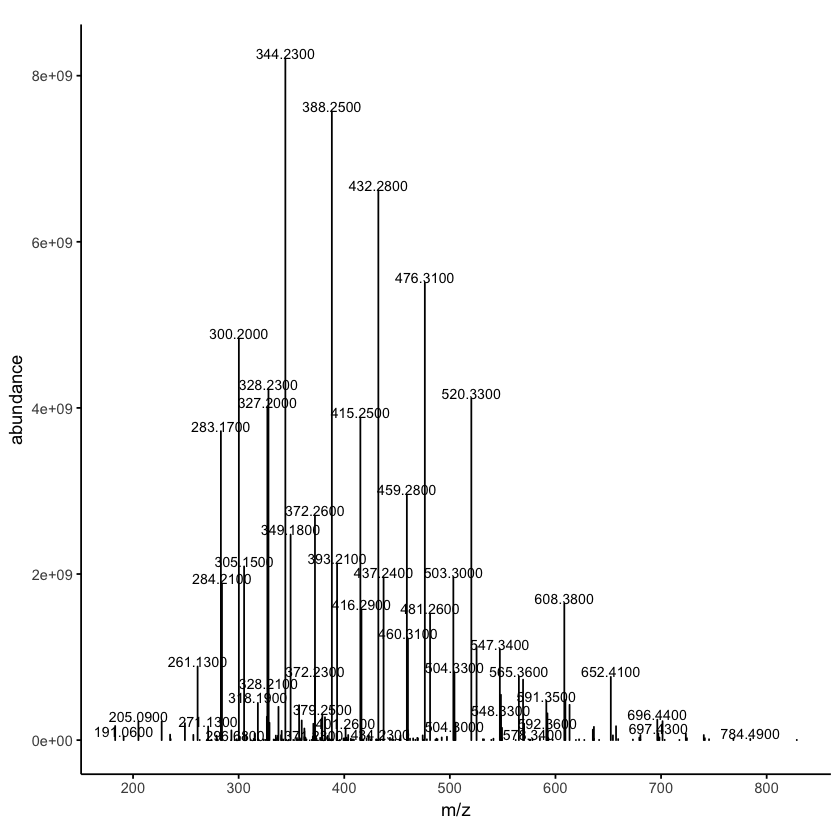

In [25]:
KMF_filtered_features_spectrum_plot <- ggplot()+
    geom_bar(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance), stat="identity",size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("m/z") +
    ylab("abundance") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(KMF_filtered_features_spectrum_plot)

create a) Kendrick mass plot, b) MS1 feature plot, c) MS1 feature spectrum prior and d) after KMF as well as e) MS1 features removed via KMF:

Saving 7.1 x 7 in image


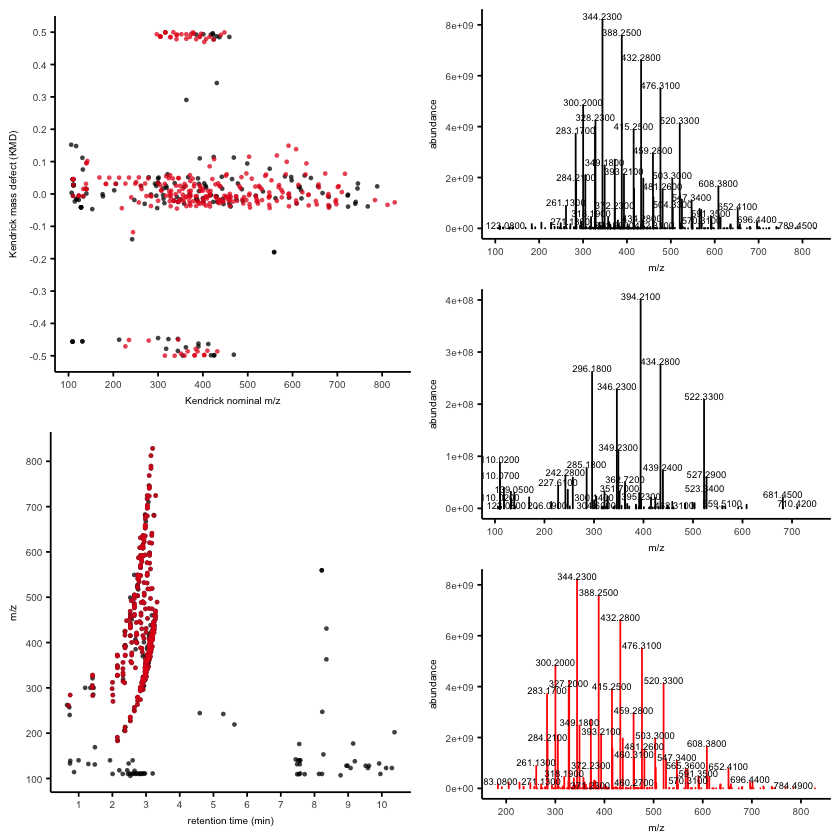

In [26]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=1, alpha=0.75, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=1, alpha=0.75,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
    
MS1featureplot <- 
    ggplot()+
    geom_point(data=as.data.frame(vec),aes(x=rt, y=mz), pch=16, 
              size=1, alpha=0.75, color="black")+
    geom_point(data=Filtered_matrix_KMF_wgraph_MS1_plot_vec, aes(x=rt, y=mz), pch=16, 
               size=1, alpha=0.75, col="#e41a1c")+
    scale_y_continuous(breaks = seq(0,1000,100))+
    scale_x_continuous(breaks = seq(0,10,1))+
        xlab("retention time (min)") +
        ylab("m/z") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)

Original_Spectrum_plot <- 
    ggplot()+
    geom_bar(data=original_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=original_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) 

KMF_spectrum_plot <- 
    ggplot()+
    geom_bar(data=KMF_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) 

KMF_filtered_features_spectrum_plot <- ggplot()+
    geom_bar(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance), stat="identity",size=0.5, alpha=1, color="red")+
    geom_text(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("m/z") +
    ylab("abundance") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6))  

lay <- rbind(c(1,3),
             c(1,3),
             c(1,4),
             c(2,4),
             c(2,5),
             c(2,5))
plot <- grid.arrange(Kendrickplot,MS1featureplot,Original_Spectrum_plot,KMF_spectrum_plot,KMF_filtered_features_spectrum_plot, layout_matrix = lay)

ggsave("20180611_KMF_Figure_PEG400.pdf", plot, scale=1, width=7.1, units="in")

save output tables to files

In [27]:
# write .csv table containing the KMF info matrix
write.csv(kendrickmassfilterinfo_diff, "20160611_PEG_KMF_info.csv", row.names=FALSE)

# write .csv table containing MS1 features remaining after Kendrick mass filtering
write.csv(output$Kendrickfiltered_MS1features_wgraph, "20160611_PEG_KMF_resultingdatamatrix.csv",row.names=FALSE)

# write .csv table of MS1 features removed from the data via the Kendrick mass filter
write.csv(Filtered_matrix_KMF_wgraph_MS1_plot_vec, "20160611_PEG_KMF_featuresfiltered.csv", row.names=FALSE)